# USB Modeling 
  - Input
    - INFOSYS_POPULATION_new.xlsx
  - Data Prepration  
  - Apply TargetEncoder to convert categorical variables to numeric data
  - Apply MinMaxScaler to nomalize data 
  - Apply KNNImputer to impute SBFE_Score and CC_Score  
  - Apply ADASYN to handle the imblance data set
  - Apply cross_val_score to various models and select the winner 
  - Build LogisticRegression model and evaluate the model
  - Build XGBClassifier model and evaluate the model
  - Notes
    - use 'pip install category-encoders' to resove "No module named 'category_encoders'" 
    - use 'pip install category-encoders --user' to resolve "No module named 'imblearn'"
    - use 'pip install xgboost' to resolve "No module named 'xgboost'"

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from category_encoders import TargetEncoder
from imblearn.over_sampling import ADASYN
from sklearn.impute import KNNImputer


from numpy import mean
from numpy import std
from numpy import absolute

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Ignore warning message

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option( 'display.max_columns', 10 )
pd.set_option('precision', 6)
pd.set_option('max_colwidth', 20)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', lambda x: '%.5f' %x)
#pd.set_printoptions(suppress = True)

In [25]:
## Evaluation
def mdl_eva(X_test, y_test, mdl, mdl_desc):
    """
     Purpose: Evaluate model and print confusion matric and classification report
     Parameters:
       Input:
       X_test: Trian test
       y_test: Test data for validation
       mdl: Model to be evaluated
       mdl_desc: Model description
    """
    print(f'{mdl_desc} Model Evalation')
    predictions = mdl.predict(X_test)
    y_pred = predictions 
    print("Accuracy Score :",metrics.accuracy_score(y_test, y_pred))
    print("Precision Score:",metrics.precision_score(y_test, y_pred))
    print("Recall Score   :",metrics.recall_score(y_test, y_pred)) 
    
    print(classification_report(y_test,predictions))
    cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=[0, 1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1'])
    print(cmtx)
    
    # Draw ROC
    # AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.
    y_pred_proba = mdl.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    plt.title("ROC for " + mdl_desc)
    plt.plot(fpr,tpr,label=" auc="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot([0,1],[0,1],'k--')
    plt.legend(loc=4)
    plt.show()

## data preparation
   - Replace column 'Decioned' by column 'target'
     - Creae a new column 'target' from 'Decision'
        - 'Declined': 1
        - 'Approved':0
     -  Remove 2 missing values from 'Channel'
     -  Remove 'NAICS_Desc', 'NAICS_Cd', 'Revw_Id', 'Revw_Month'
        - will not use these colmns for modeling

In [5]:
path = 'C:\\Users\\sophia.yue\\Infosys\\Sandeep Project\\'
df = pd.read_excel(path + "INFOSYS_POPULATION_new.xlsx", sheet_name = 'INFOSYS_POPULATION_new', engine = 'openpyxl' )
#df.head(3).T
#df.head()
#df.shape
#df.describe()
#df.info()

df.Decision.value_counts()             
targ_dict = {'Declined': 1, 'Approved':0 }
df['target'] = [targ_dict[yy] for yy in df.Decision]
df.target.value_counts() 
df = df.dropna(subset = ['Channel'])  # drop missing values from channel
l_col_rem = ['NAICS_Desc', 'NAICS_Cd', 'Revw_Id', 'Revw_Month', 'Decision' ]
df.drop(l_col_rem, axis = 1,  inplace = True)
card_typ = ['Corporate_Card','Purchasing_Card','One_Card','Other_NonBankCard']
#df.astype({'Corporate_Card':'category',
df.astype({'Corporate_Card':'object',
           'Purchasing_Card':'object',
           'One_Card':'object',
           'Other_NonBankCard':'object'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2481 entries, 0 to 2482
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Org_Struc_Desc                 2481 non-null   object 
 1   Revw_Quarter                   2481 non-null   object 
 2   Scored_Flag                    2481 non-null   object 
 3   Elan_Flag                      2481 non-null   object 
 4   CLI_or_New_Prod_Flag           2481 non-null   object 
 5   Channel                        2481 non-null   object 
 6   Corporate_Card                 2481 non-null   int64  
 7   Purchasing_Card                2481 non-null   int64  
 8   One_Card                       2481 non-null   int64  
 9   Other_NonBankCard              2481 non-null   int64  
 10  Scored_Rec_Decision            2481 non-null   object 
 11  SBFE_Score                     2031 non-null   float64
 12  CC_Score                       1919 non-null   f

## Get columns for type with objective and numeric   
 - l_col_obj : get features with datatype = obj
   - include card number in l_col_obj


In [6]:
l_col_obj = df.dtypes[df.dtypes == 'O'].index.tolist() 
#l_col_obj_rem = ['NAICS_Desc', 'Revw_Month', 'Revw_Quarter']
#l_col_obj = [ x for x in l_col_obj if x not in l_col_obj_rem]
#card_typ = ['Corporate_Card','Purchasing_Card','One_Card','Other_NonBankCard']
#l_col_obj.extend(card_typ)
print(l_col_obj)

['Org_Struc_Desc', 'Revw_Quarter', 'Scored_Flag', 'Elan_Flag', 'CLI_or_New_Prod_Flag', 'Channel', 'Scored_Rec_Decision', 'Financial_Template_Found_Flag']


## Categorical feature encoding 
  - Invoke 'impute_cat' to impute missing values
  - Define a function 'tar_enc' to use target encoding to convert categorical feature to numerical feature
  - Will apply to all categorical features


In [7]:
#Apply target encoding for df
for feature in l_col_obj:
    tenc=ce.TargetEncoder() 
    df_fea =tenc.fit_transform(df[feature],df['target'])
    df[feature] = df_fea 

## scale the numerical features

In [8]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df.head(3)

,Org_Struc_Desc,Revw_Quarter,Scored_Flag,Elan_Flag,CLI_or_New_Prod_Flag,...,Financial_Template_Found_Flag,Existing_Limit,Request_Amount,Final_Limit,target
0,0.26812,0.38418,1.00000,0.00000,0.00000,...,1.00000,0.20238,0.11000,0.28000,0.00000
1,0.17471,0.38418,1.00000,0.00000,0.00000,...,1.00000,0.11905,0.10000,0.10000,1.00000
2,0.00000,0.38418,1.00000,0.00000,1.00000,...,1.00000,0.00000,1.00000,1.00000,0.00000


## Impute numerical feature

In [9]:
imputer = KNNImputer(n_neighbors=5)
#df =  pd.DataFrame(imputer.fit_transform(df),columns = df.columns)       
#df['SBFE_Score'] = pd.DataFrame(imputer.fit_transform(df),columns = 'SBFE_Score')
df["SBFE_Score"] = imputer.fit_transform(df[["SBFE_Score"]]).ravel()
df['CC_Score'] = imputer.fit_transform(df[['CC_Score']]).ravel()
df.head(3)                   

,Org_Struc_Desc,Revw_Quarter,Scored_Flag,Elan_Flag,CLI_or_New_Prod_Flag,...,Financial_Template_Found_Flag,Existing_Limit,Request_Amount,Final_Limit,target
0,0.26812,0.38418,1.00000,0.00000,0.00000,...,1.00000,0.20238,0.11000,0.28000,0.00000
1,0.17471,0.38418,1.00000,0.00000,0.00000,...,1.00000,0.11905,0.10000,0.10000,1.00000
2,0.00000,0.38418,1.00000,0.00000,1.00000,...,1.00000,0.00000,1.00000,1.00000,0.00000


In [10]:
df.isnull().any()

Org_Struc_Desc                   False
Revw_Quarter                     False
Scored_Flag                      False
Elan_Flag                        False
CLI_or_New_Prod_Flag             False
Channel                          False
Corporate_Card                   False
Purchasing_Card                  False
One_Card                         False
Other_NonBankCard                False
Scored_Rec_Decision              False
SBFE_Score                       False
CC_Score                         False
Financial_Template_Found_Flag    False
Existing_Limit                   False
Request_Amount                   False
Final_Limit                      False
target                           False
dtype: bool

## ADASYN - to handle imbalance data
  - The ADASYN (adaptive synthetic sampling) approach
  - uses a weighted distribution for different minority class examples according to their level of difficulty in learning
    - where more synthetic data is generated for minority class examples that are harder to learn.
    - fit_sample had been ewplaced by fit_resample  

In [11]:
y = df["target"]
X = df.drop('target', axis = 1)
ada = ADASYN() 
X_resampled, y_resampled = ada.fit_resample(X, y) 


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.20, 
                                                    random_state=101)

##  Apply cross_val_score to various models and select the winner

In [13]:
models = []
#models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LGR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('XGB', XGBClassifier()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results  = cross_val_score(model, X_resampled, y_resampled, scoring='roc_auc', cv=cv, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LGR: 0.995155 (0.002250)
LDA: 0.990203 (0.004463)
KNN: 0.986451 (0.004700)
CART: 0.991359 (0.005503)
NB: 0.877215 (0.016530)
XGB: 0.999985 (0.000044)
SVM: 0.994754 (0.002132)


##  XGBClassifier is the winner
    - will build LogisticRegression Model and XGBClassifier model

###  Build LogisticRegression Model & evaluation


In [15]:
lgr = LogisticRegression() 
# fit the model
lgr.fit(X_train, y_train)
# get importance
#feature_importance = mdl.coef_[0]
#feature_importance = mdl.coef_[0][::-1]
feature_importance = lgr.coef_[0]


### Summarize coefficients 

In [16]:

pd.DataFrame(feature_importance, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
Existing_Limit,9.49741
Request_Amount,6.60277
Org_Struc_Desc,2.39490
Financial_Template_Found_Flag,2.06713
Scored_Rec_Decision,1.61194
Corporate_Card,0.81513
Channel,0.42213
One_Card,0.16326
Revw_Quarter,0.12714
Purchasing_Card,0.00693


In [17]:
coef_aft_exp = np.exp(feature_importance)
pd.DataFrame(coef_aft_exp, 
             X.columns, 
             columns=['coef_aft_exp'])\
            .sort_values(by='coef_aft_exp', ascending=False)

,coef_aft_exp
Existing_Limit,13325.16567
Request_Amount,737.13118
Org_Struc_Desc,10.96705
Financial_Template_Found_Flag,7.90208
Scored_Rec_Decision,5.01252
Corporate_Card,2.25946
Channel,1.52520
One_Card,1.17734
Revw_Quarter,1.13558
Purchasing_Card,1.00696


### Evaluate model

LogisticRegression Model Evalation
Accuracy Score : 0.9622132253711201
Precision Score: 0.9516539440203562
Recall Score   : 0.9765013054830287
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       358
         1.0       0.95      0.98      0.96       383

    accuracy                           0.96       741
   macro avg       0.96      0.96      0.96       741
weighted avg       0.96      0.96      0.96       741

        pred:0  pred:1
true:0     339      19
true:1       9     374


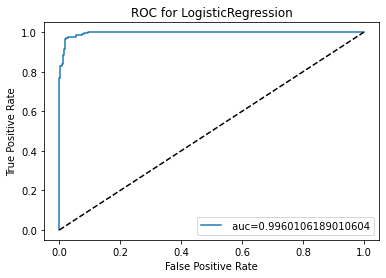

In [26]:
mdl_eva(X_test, y_test, lgr,'LogisticRegression')

### Build XGBClassaifier model

In [27]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [28]:
pd.DataFrame(xgb.feature_importances_, 
             X.columns, 
             columns=['feature_importances'])\
            .sort_values(by='feature_importances', ascending=False)
                       
                         

,feature_importances
Final_Limit,0.47917
Existing_Limit,0.26756
Org_Struc_Desc,0.08678
Request_Amount,0.07060
Financial_Template_Found_Flag,0.03548
Scored_Rec_Decision,0.02697
Revw_Quarter,0.01210
CC_Score,0.00589
Other_NonBankCard,0.00562
SBFE_Score,0.00496


XGBClassifier Model Evalation
Accuracy Score : 1.0
Precision Score: 1.0
Recall Score   : 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       358
         1.0       1.00      1.00      1.00       383

    accuracy                           1.00       741
   macro avg       1.00      1.00      1.00       741
weighted avg       1.00      1.00      1.00       741

        pred:0  pred:1
true:0     358       0
true:1       0     383


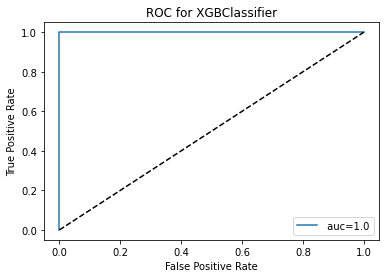

In [29]:
mdl_eva(X_test, y_test, xgb,'XGBClassifier')

In [ ]:
stop
mdl = LogisticRegression() 
scores = cross_val_score(mdl, X_resampled, y_resampled, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize the model performance
print(f'AUC score Mean: {mean(scores):.3f}, Std: {std(scores):.3f}')

In [ ]:
df.columns

In [ ]:
len(y_resampled) #  3704
len(y)  # 2481
y.value_counts() # 0:1848 1: 633
y_resampled.value_counts()#1: 1856, 0: 1848

In [ ]:
len(X_test)

In [ ]:
sorted_idx = np.argsort(mdl.coef_[0])[::-1]
for index in sorted_idx:
    print([X.columns[index], mdl.coef_[0][index]]) 

In [ ]:
# define the model cross-validation configuration   
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# evaluate the pipeline using cross validation and calculate MAE
mdl = LogisticRegression() 
scores = cross_val_score(mdl, X_resampled, y_resampled, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize the model performance
print(f'AUC score Mean: {mean(scores):.3f}, Std: {std(scores):.3f}')

In [ ]:
sorted_idx = np.argsort(xgb.feature_importances_)[::-1]
for index in sorted_idx:
    print([X.columns[index], xgb.feature_importances_[index]]) 

In [ ]:
              feature_importances
Final_Limit     0.47575
Existing_Limit  0.28660
Org_Struc_Desc  0.07265
Request_Amount  0.06915
Financial_Template_Found_Flag	0.04756
Revw_Quarter    0.01390
SBFE_Scor       0.01382
Channel         0.00911
Elan_Flag       0.00828
CC_Score        0.00318
CLI_or_New_Prod_Flag 0.00000
Corporate_Card       0.00000
Purchasing_Card      0.00000
Other_NonBankCard    0.00000
Scored_Rec_Decision  0.00000
Scored_Flag          0.00000
One_Card             0.00000